## In this notebook, we use Care for pair wise training. Q0.
## CM02: Q0_o, Q1_o, Q2_o, Q3_o, Q4_o, Q4_i, Q3_i, Q2_i, Q1_i, Q0_i
## CM03: Q0_i, Q1_i, Q2_i, Q3_i, Q4_i, Q4_o, Q3_o, Q2_o, Q1_o, Q0_o

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from csbdeep.utils import axes_dict, plot_some, plot_history
from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.io import load_training_data
from csbdeep.models import Config, CARE
import glob
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
import copy


Using TensorFlow backend.


## Load Input and Output Data 

In [2]:
filenames = glob.glob("/home/lalit/Desktop/03_Datasets/KellerLab/Data/CM02_flipped/*.tif")
filenames.sort()
imgs = [imread(img).astype('float64') for img in filenames]

print(len(imgs))
print("Typical shape:",  imgs[0].shape)
print("Typical datatype:", imgs[0].dtype)

10
Typical shape: (70, 896, 576)
Typical datatype: float64


## Take only the last seven  z-slices as input from CM02

In [3]:
X_CM02=[]
for i in range(len(imgs)):
    temp=imgs[i][-7:, ...]
    X_CM02.append(temp)
print(X_CM02[5].shape)

(7, 896, 576)


## Take only the first seven z-slices as output from CM02

In [5]:
Y_CM02=[]
for i in range(len(imgs)):
    temp=imgs[i][:7, ...]
    Y_CM02.append(temp)
print(Y_CM02[5].shape)

(7, 896, 576)


## Load images from CM03

In [6]:
filenames = glob.glob("/home/lalit/Desktop/03_Datasets/KellerLab/Data/CM03/*.tif")
filenames.sort()
imgs = [imread(img).astype('float64') for img in filenames]

print("Typical shape:",  imgs[0].shape)
print("Typical datatype:", imgs[0].dtype)

Typical shape: (70, 896, 576)
Typical datatype: float64


## Take only the first seven z-slices from CM03 as input

In [7]:
X_CM03=[]
for i in range(len(imgs)):
    temp=imgs[i][:7, ...]
    X_CM03.append(temp)
print(X_CM03[5].shape)

(7, 896, 576)


## Take only the last seven z-slices from CM03 as output

In [8]:
Y_CM03=[]
for i in range(len(imgs)):
    temp=imgs[i][-7:, ...]
    Y_CM03.append(temp)
print(Y_CM03[5].shape)

(7, 896, 576)


## Combine X_CM02 and X_CM03

In [9]:
imgsX=X_CM02+X_CM03
print(len(imgsX))
print(imgsX[5].shape)

20
(7, 896, 576)


In [10]:
imgsY=Y_CM03+Y_CM02
print(len(imgsY))
print(imgsY[5].shape)

20
(7, 896, 576)


## Visualize the images 

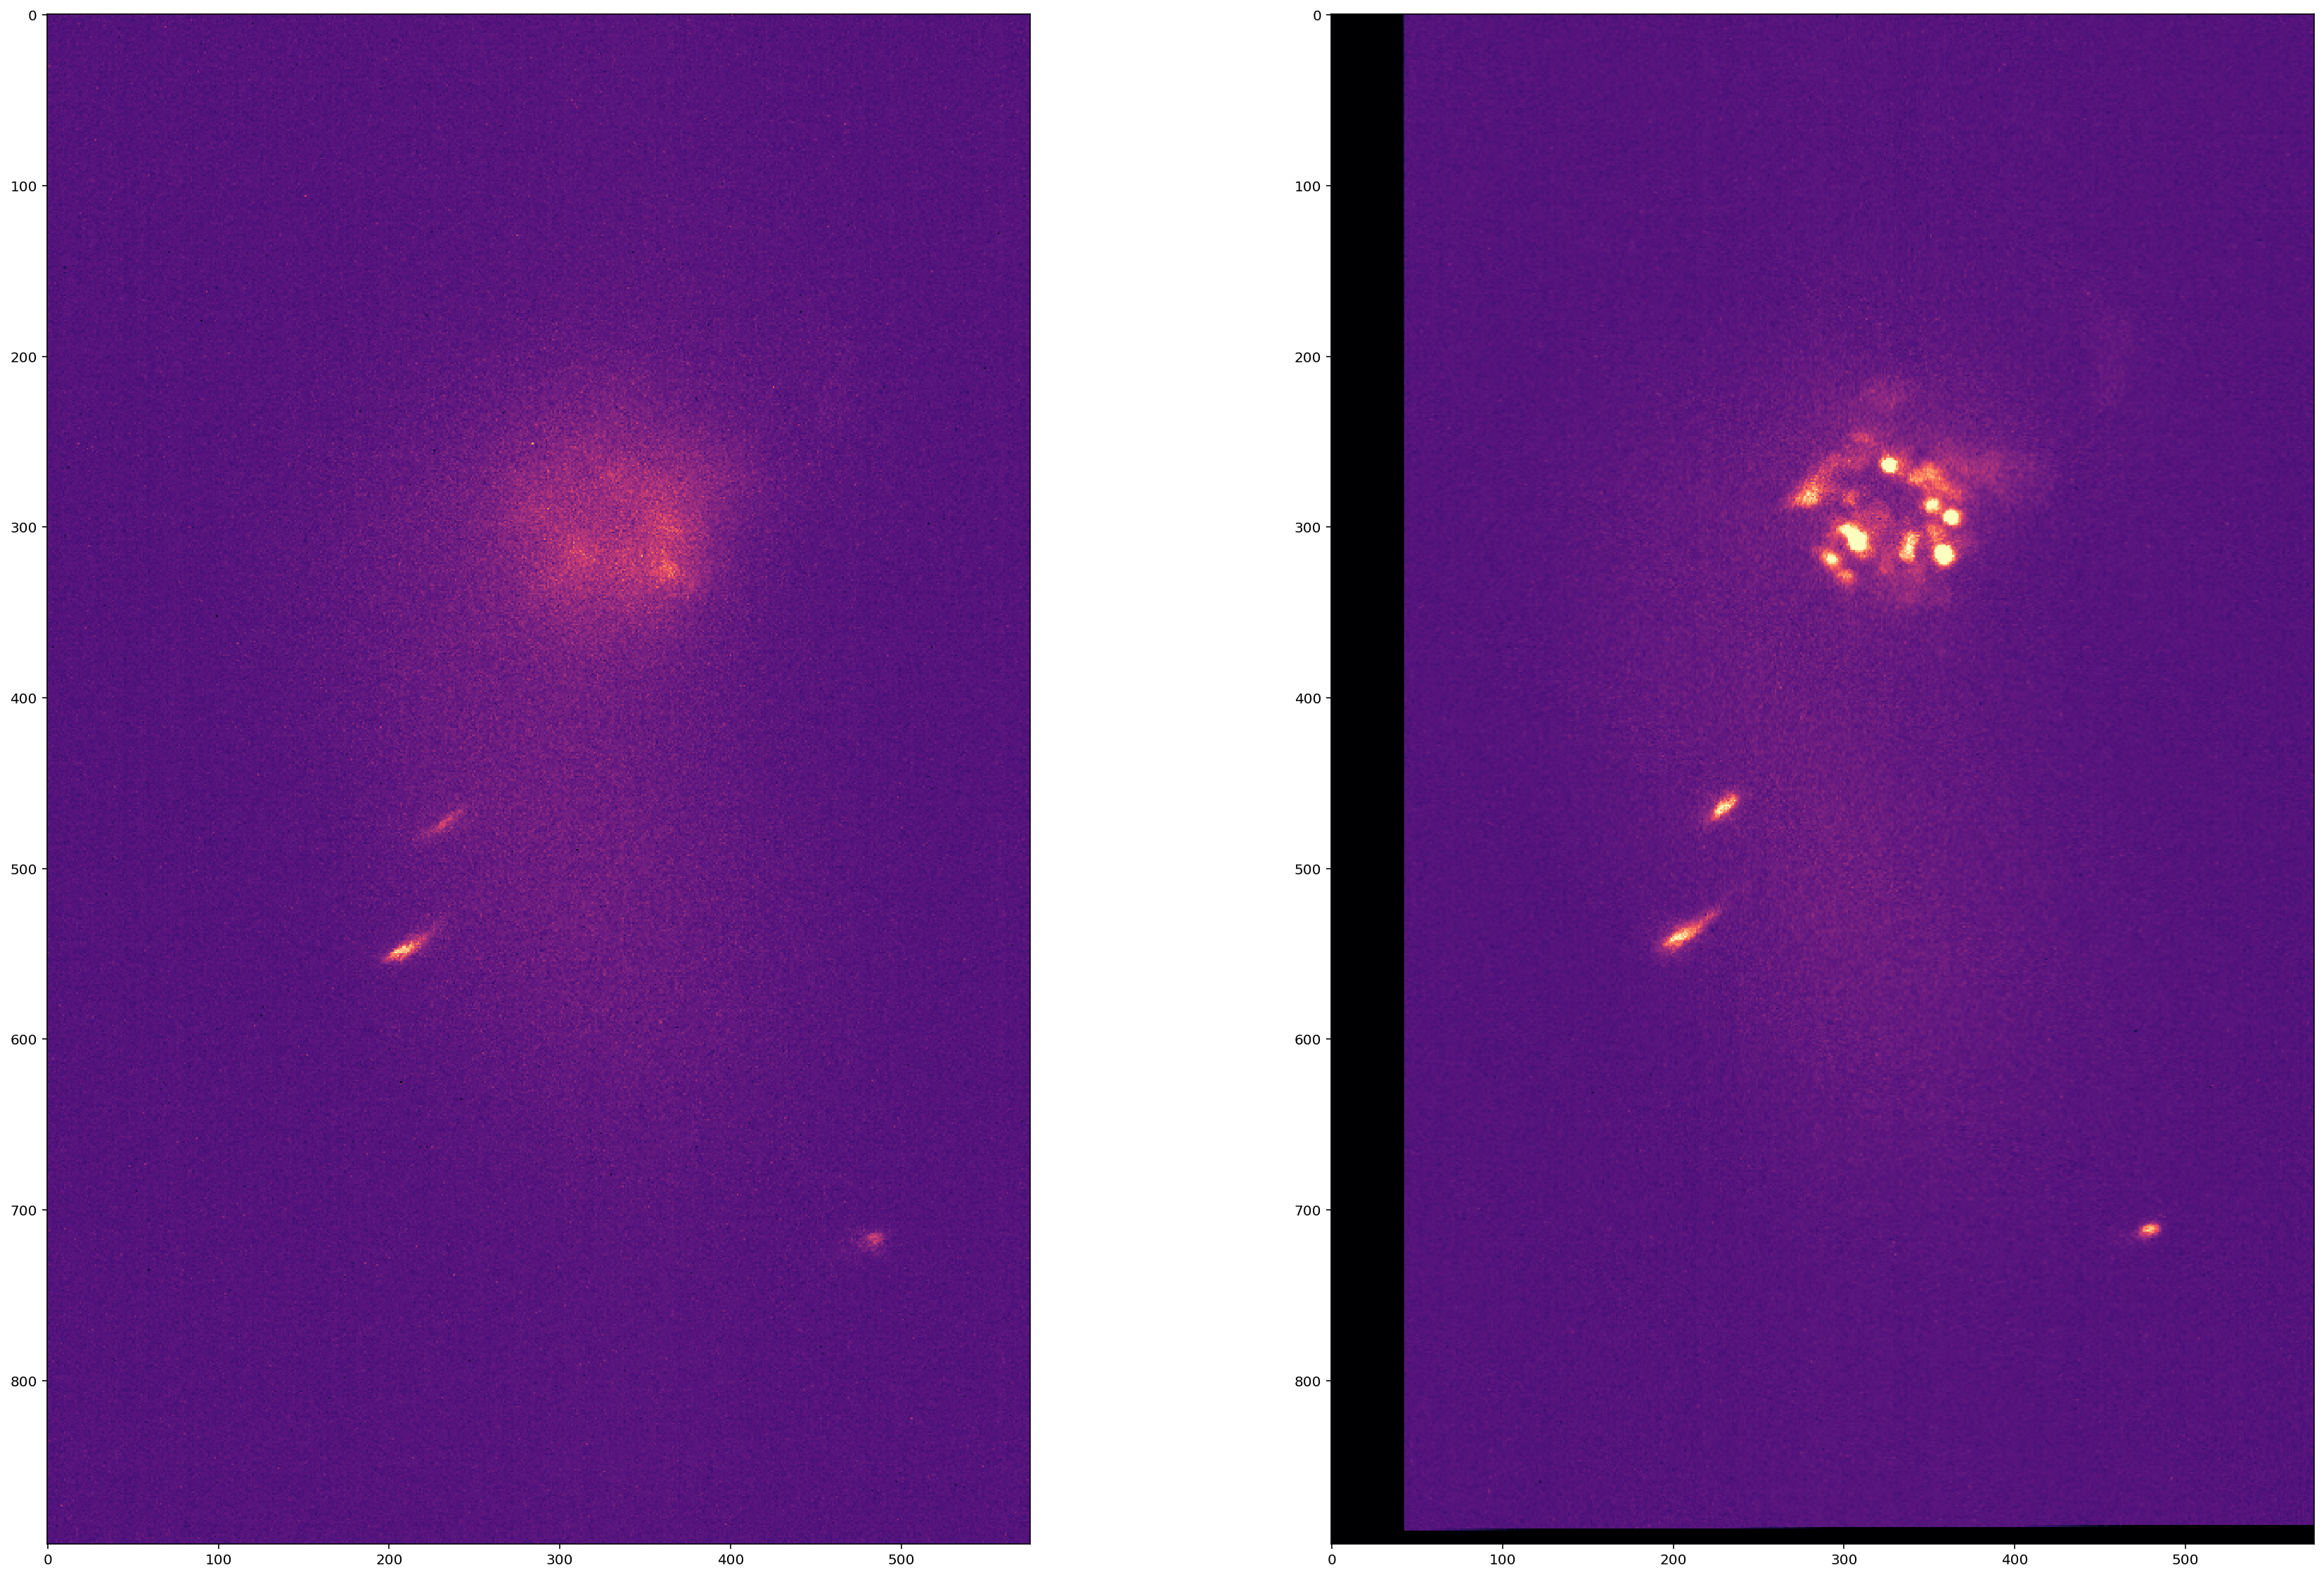

In [11]:
vmin=np.min(imgsX[14][5,...])
vmax=np.max(imgsX[14][5,...])
plt.figure(figsize=(30,20))
plt.subplot(1,2,1)
plt.imshow(imgsX[14][5,...], cmap='magma', vmin=vmin, vmax=vmax)
plt.subplot(1,2,2)
plt.imshow(imgsY[14][5,...], cmap='magma', vmin=vmin, vmax=vmax)
plt.show()

## Since there is an artificial margin in the input and the output, we chop away the first and last 60 in the x dimension and in the y dimension

In [12]:
imgsX_chopped=[]
imgsY_chopped=[]
for i in range(len(imgsX)):
    imgsX_chopped.append(imgsX[i][:, 60:-60, 60:-60])
    imgsY_chopped.append(imgsY[i][:, 60:-60, 60:-60])

## Visualize the images again

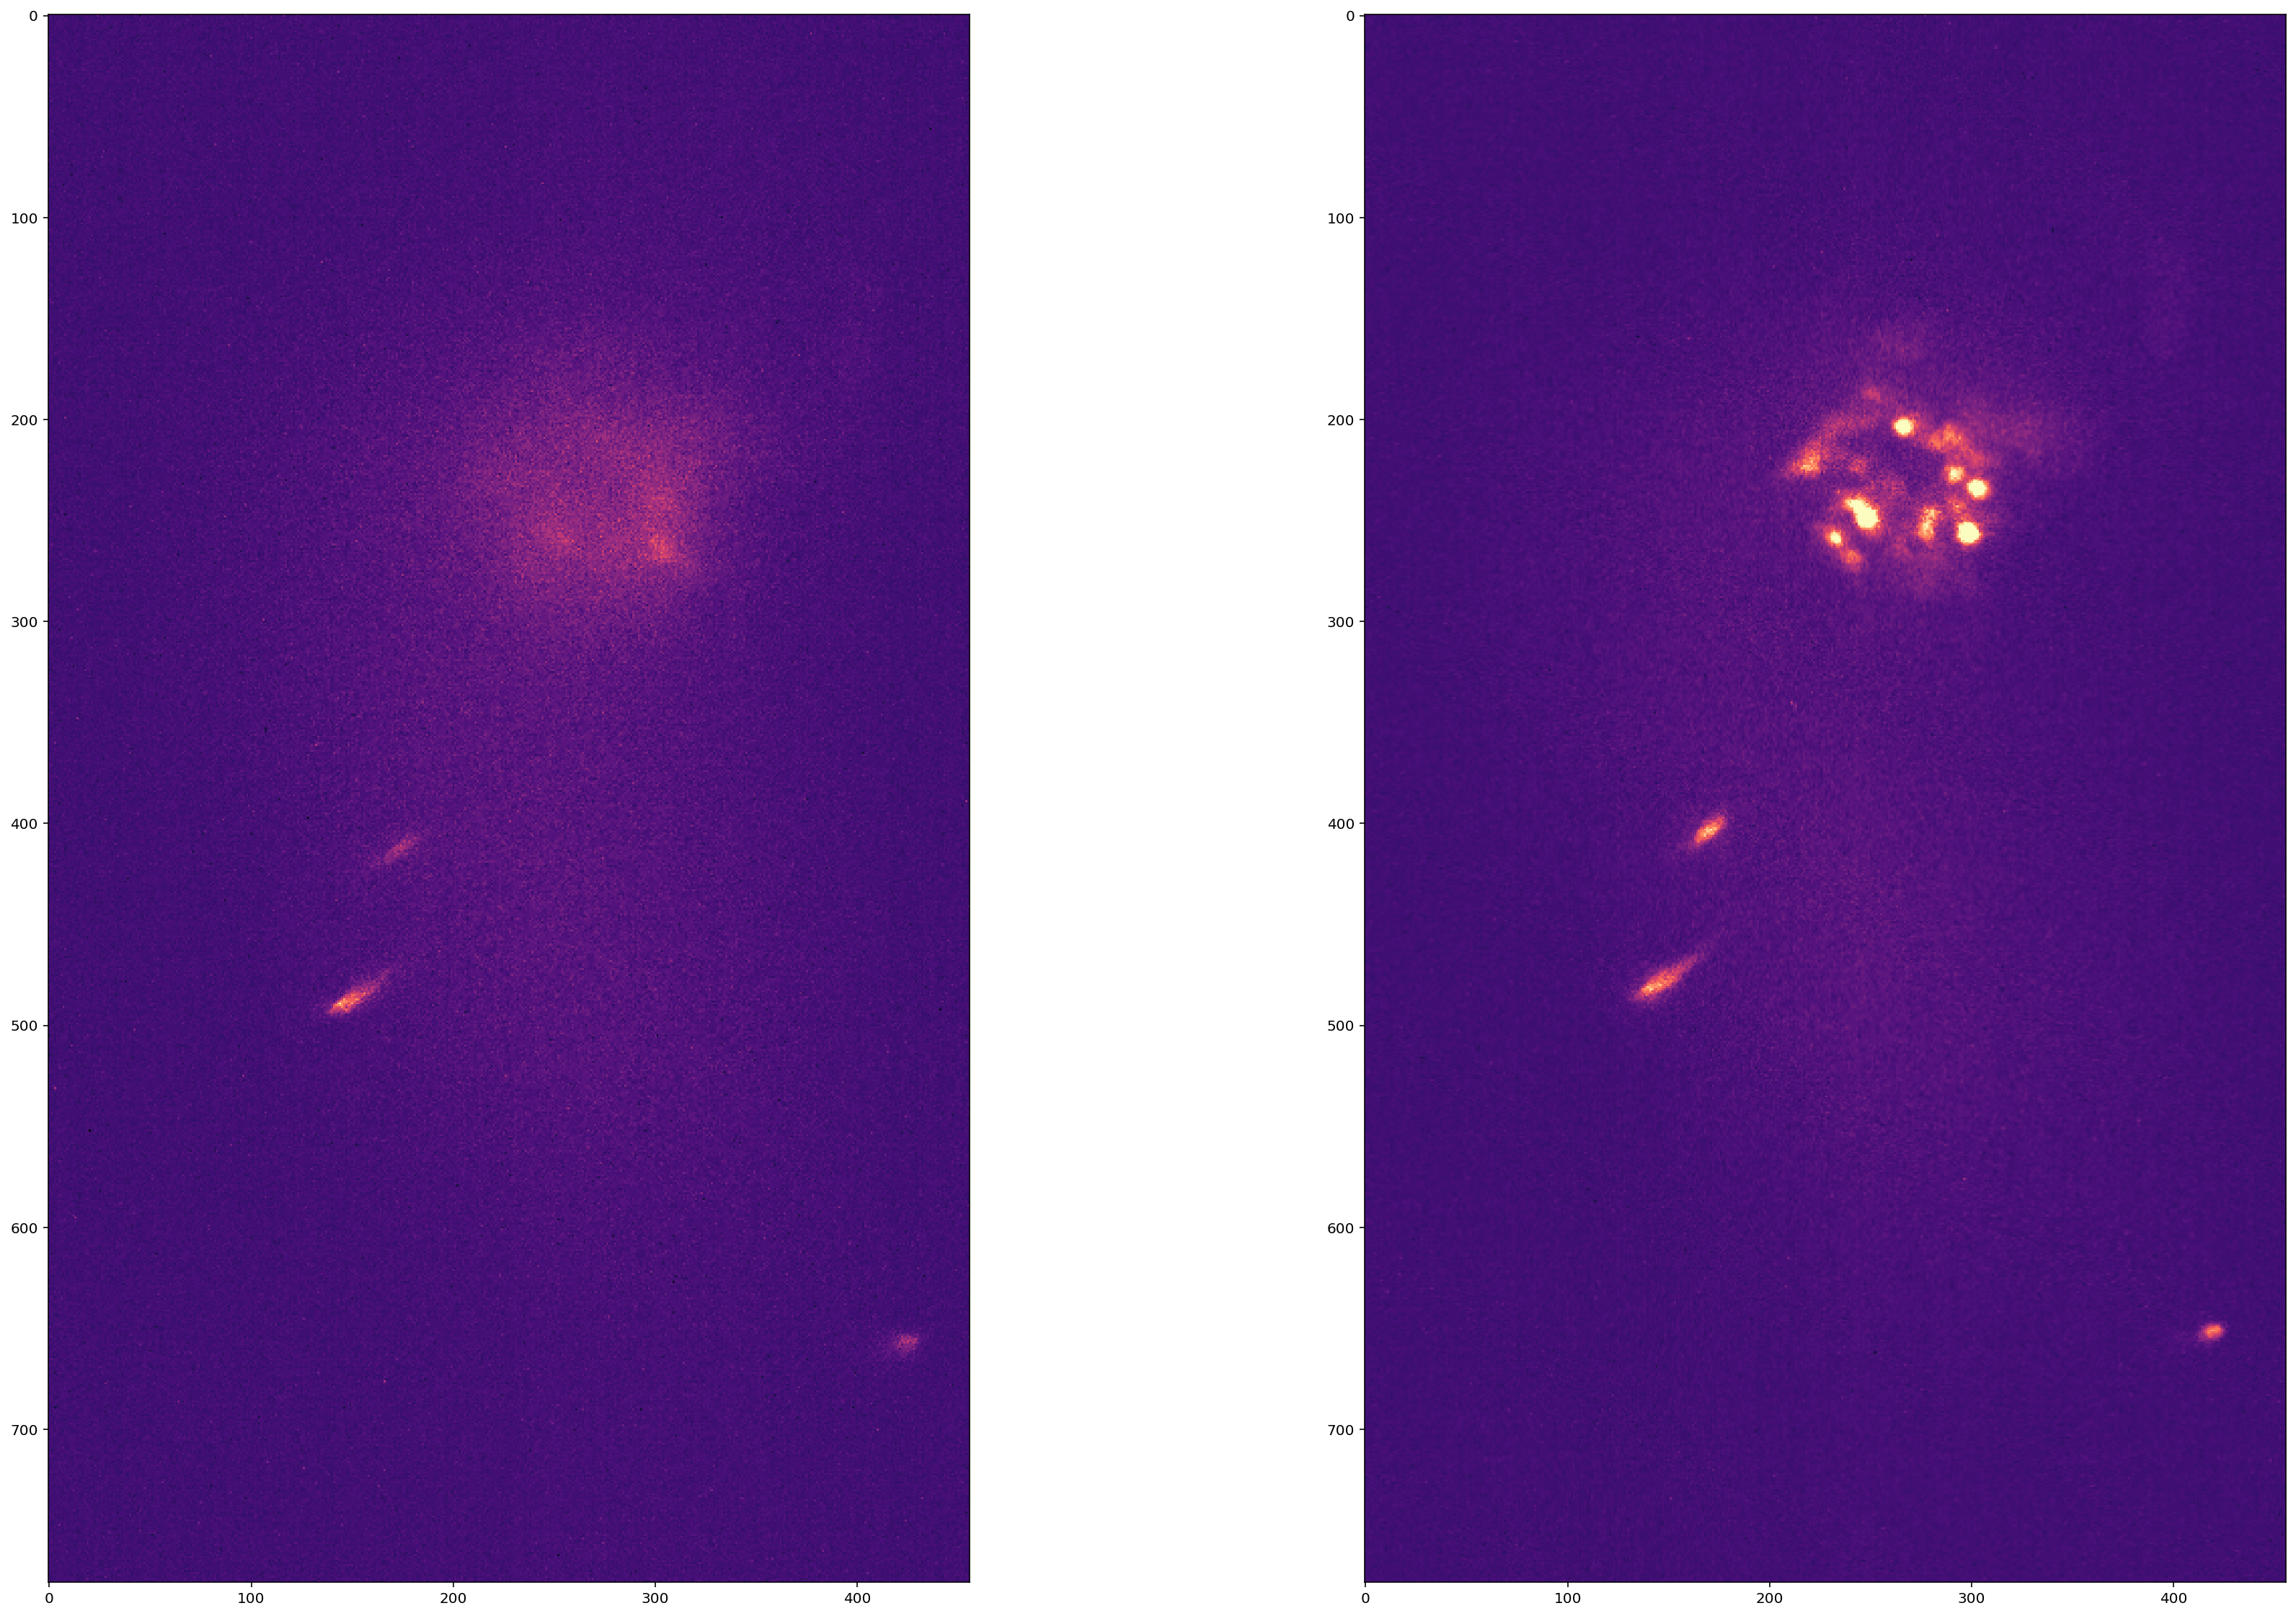

In [13]:
vmin=np.min(imgsX_chopped[15][5,...])
vmax=np.max(imgsX_chopped[15][5,...])
plt.figure(figsize=(30,20))
plt.subplot(1,2,1)
plt.imshow(imgsX_chopped[15][5,...], cmap='magma', vmin=vmin, vmax=vmax)
plt.subplot(1,2,2)
plt.imshow(imgsY_chopped[15][5,...], cmap='magma', vmin=vmin, vmax=vmax)
plt.show()

## Also we must normalize the patches, prior to training !!

In [14]:
mean=np.mean(imgsX_chopped)
print(mean)
std=np.std(imgsX_chopped)
print(std)

102.89431263807069
5.411731522138403


## Create patches

In [15]:
imgsX_chopped=np.concatenate(imgsX_chopped, axis=0)
print(imgsX_chopped.shape)
imgsY_chopped=np.concatenate(imgsY_chopped, axis=0)
print(imgsY_chopped.shape)

(140, 776, 456)
(140, 776, 456)


In [16]:
combined=np.empty([np.shape(imgsX_chopped)[0], np.shape(imgsX_chopped)[1], np.shape(imgsX_chopped)[2], 2])
combined[..., 0]=imgsX_chopped
combined[..., 1]=imgsY_chopped
# Normalization Step
combined=(combined-mean)/std
print(combined.dtype)

float64


In [17]:
combinedList=[]
combinedList.append(combined)
print(len(combinedList))

1


## Augment is set to True

In [18]:
datagen = N2V_DataGenerator()
patches = datagen.generate_patches_from_list(combinedList, shape=(96, 96), augment=True)
print(patches.shape)

Generated patches: (35840, 96, 96, 2)
(35840, 96, 96, 2)


## Create train and validation pairs

In [19]:
X=patches[:-1000,..., 0]
X=X[..., np.newaxis]
Y=patches[:-1000, ..., 1]
Y=Y[..., np.newaxis]
X_val=patches[-1000:,..., 0]
X_val=X_val[..., np.newaxis]
Y_val=patches[-1000:, ..., 1]
Y_val=Y_val[..., np.newaxis]
print("X shape: ", X.shape)
print("Y shape: ", Y.shape)
print("X_val shape: ", X_val.shape)
print("Y_val shape: ", Y_val.shape)

X shape:  (34840, 96, 96, 1)
Y shape:  (34840, 96, 96, 1)
X_val shape:  (1000, 96, 96, 1)
Y_val shape:  (1000, 96, 96, 1)


In [20]:
print("Datatype is:", patches[0, ..., 0].dtype)

Datatype is: float64


## Plot some examples from validation data

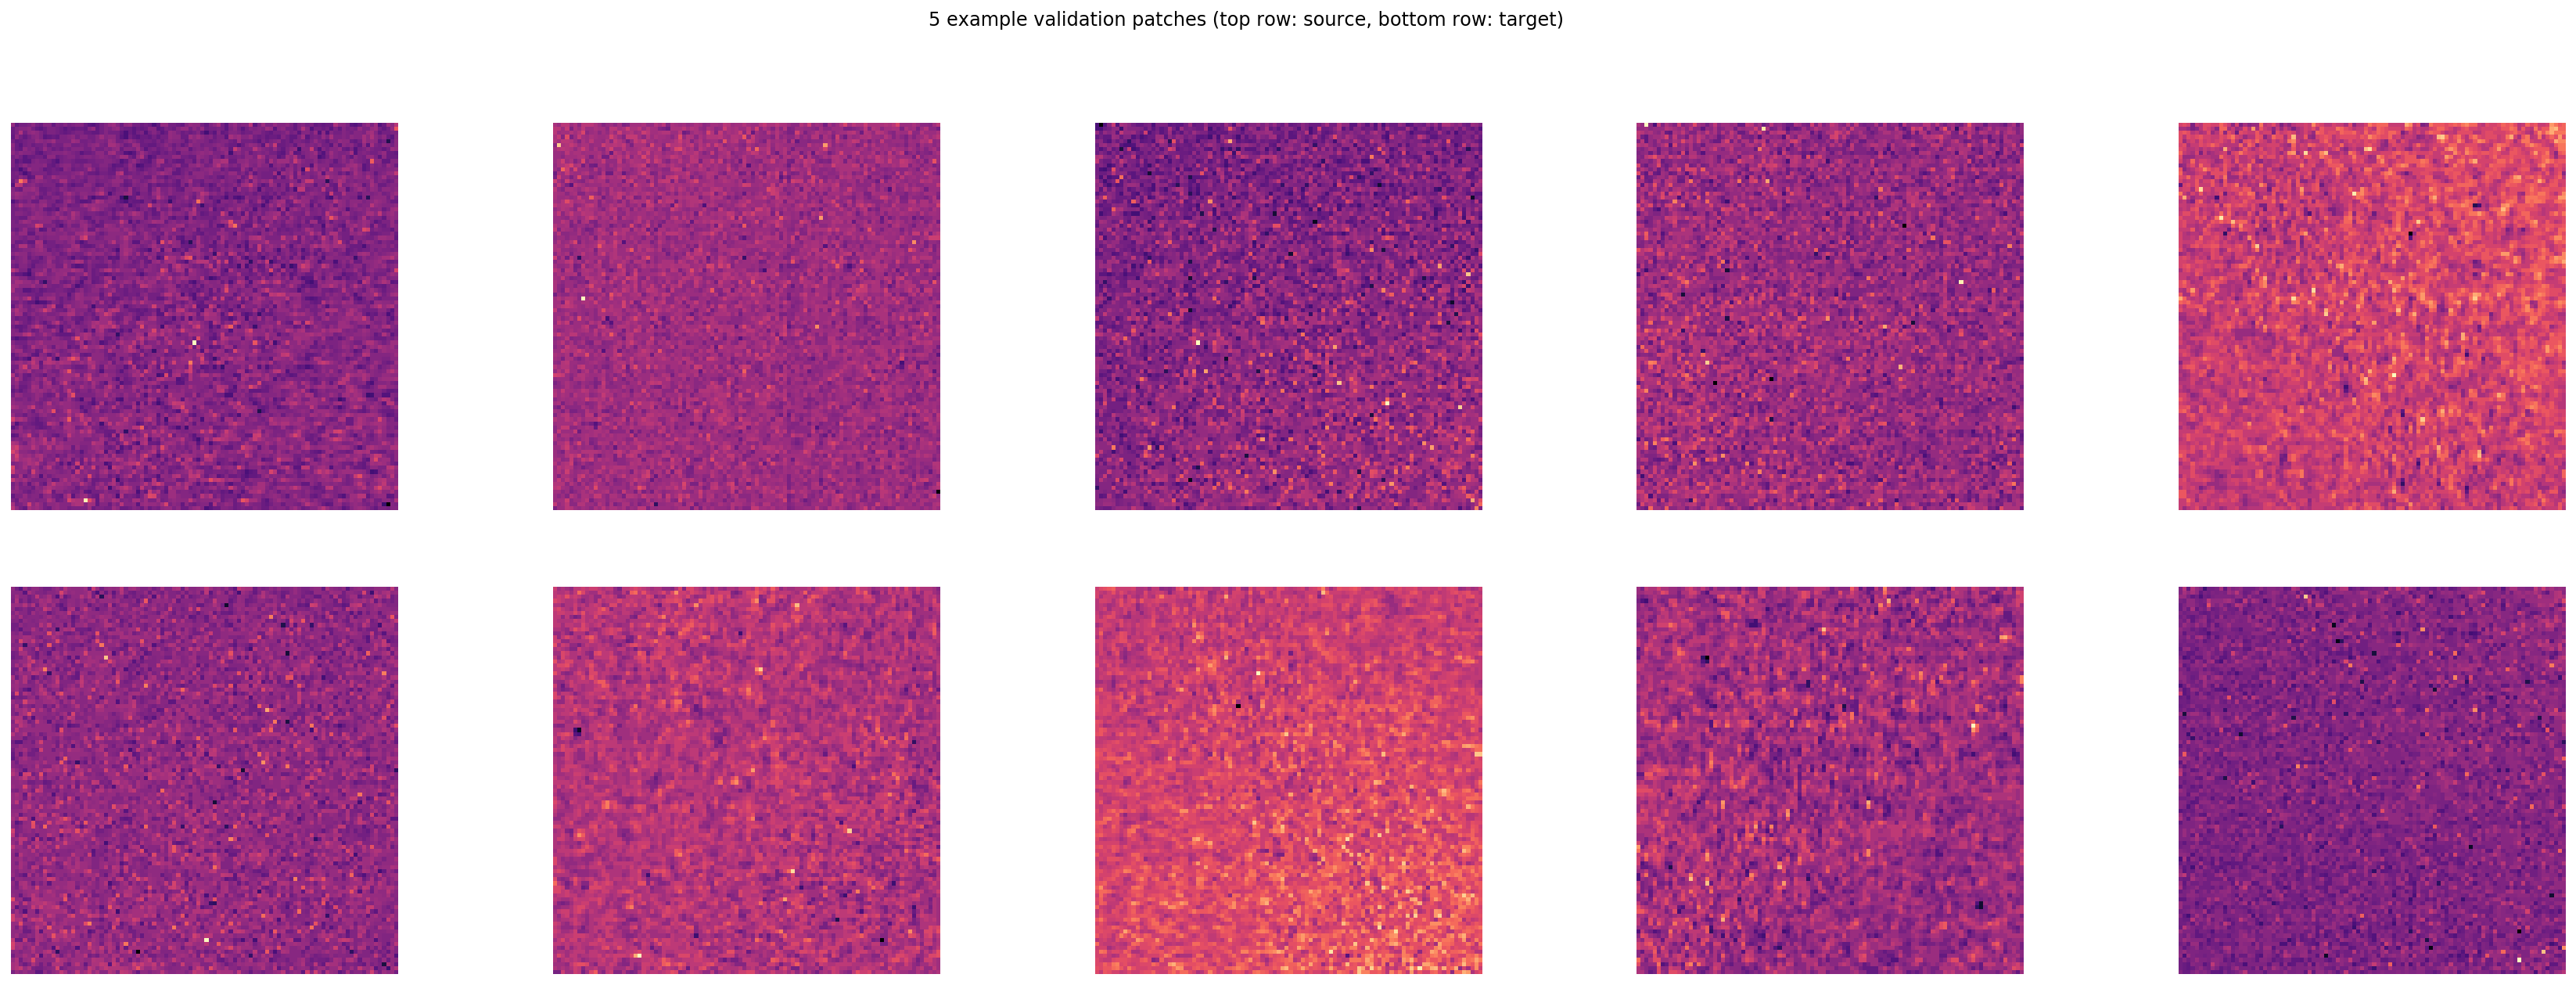

In [21]:
plt.figure(figsize=(30,10))
plot_some(X_val[400:405, ...],Y_val[400:405, ...])
plt.suptitle('5 example validation patches (top row: source, bottom row: target)');

In [22]:
axes='SYXC'
n_channel_in=1
n_channel_out=1
config = Config(axes, n_channel_in, n_channel_out, probabilistic=False, train_steps_per_epoch=250, train_epochs=300, unet_n_first=64, unet_n_depth=3, unet_residual=False)
print(config)
vars(config)

Config(axes='YXC', n_channel_in=1, n_channel_out=1, n_dim=2, probabilistic=False, train_batch_size=16, train_checkpoint='weights_best.h5', train_epochs=300, train_learning_rate=0.0004, train_loss='mae', train_reduce_lr={'factor': 0.5, 'patience': 10, 'min_delta': 0}, train_steps_per_epoch=250, train_tensorboard=True, unet_input_shape=(None, None, 1), unet_kern_size=5, unet_last_activation='linear', unet_n_depth=3, unet_n_first=64, unet_residual=False)


{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'probabilistic': False,
 'unet_residual': False,
 'unet_n_depth': 3,
 'unet_kern_size': 5,
 'unet_n_first': 64,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'mae',
 'train_epochs': 300,
 'train_steps_per_epoch': 250,
 'train_learning_rate': 0.0004,
 'train_batch_size': 16,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10, 'min_delta': 0}}

In [23]:
model = CARE(config, 'care_2D_kellerlab_with_normalization_with_HandRegistration_float64_Q0_ne300_es250', basedir='models')

In [24]:
history = model.train(X,Y, validation_data=(X_val,Y_val))

/home/lalit/Desktop/02_SoftwareExecutables/anaconda3/envs/n2vmultiviewEnv/lib/python3.6/site-packages/csbdeep/models/care_standard.py:259: UserWarning: small number of validation images (only 2.8% of all images)
  warnings.warn("small number of validation images (only %.1f%% of all images)" % (100*frac_val))


Epoch 1/300
250/250 [==============================] - 26s 105ms/step - loss: 0.5006 - mse: 1.1914 - mae: 0.5006 - val_loss: 0.5130 - val_mse: 1.2552 - val_mae: 0.5130
Epoch 2/300
250/250 [==============================] - 23s 93ms/step - loss: 0.4816 - mse: 0.9482 - mae: 0.4816 - val_loss: 0.4996 - val_mse: 1.2670 - val_mae: 0.4996
Epoch 3/300
250/250 [==============================] - 23s 94ms/step - loss: 0.4975 - mse: 1.2473 - mae: 0.4975 - val_loss: 0.4966 - val_mse: 1.2874 - val_mae: 0.4966
Epoch 4/300
250/250 [==============================] - 24s 95ms/step - loss: 0.4908 - mse: 1.0935 - mae: 0.4908 - val_loss: 0.5011 - val_mse: 1.3291 - val_mae: 0.5011
Epoch 5/300
250/250 [==============================] - 24s 95ms/step - loss: 0.4947 - mse: 1.1295 - mae: 0.4947 - val_loss: 0.4993 - val_mse: 1.3601 - val_mae: 0.4993
Epoch 6/300
250/250 [==============================] - 24s 96ms/step - loss: 0.4839 - mse: 0.9667 - mae: 0.4839 - val_loss: 0.4963 - val_mse: 1.3142 - val_mae: 0.49

Epoch 50/300
250/250 [==============================] - 24s 96ms/step - loss: 0.4787 - mse: 1.1197 - mae: 0.4787 - val_loss: 0.4873 - val_mse: 1.2283 - val_mae: 0.4873
Epoch 51/300
250/250 [==============================] - 24s 94ms/step - loss: 0.4805 - mse: 0.9872 - mae: 0.4805 - val_loss: 0.4895 - val_mse: 1.1289 - val_mae: 0.4895
Epoch 52/300
250/250 [==============================] - 24s 94ms/step - loss: 0.4747 - mse: 0.9059 - mae: 0.4747 - val_loss: 0.4848 - val_mse: 1.1809 - val_mae: 0.4848
Epoch 53/300
250/250 [==============================] - 24s 97ms/step - loss: 0.4755 - mse: 1.0627 - mae: 0.4755 - val_loss: 0.4861 - val_mse: 1.1852 - val_mae: 0.4861
Epoch 54/300
250/250 [==============================] - 24s 95ms/step - loss: 0.4744 - mse: 0.9338 - mae: 0.4744 - val_loss: 0.4872 - val_mse: 1.2181 - val_mae: 0.4872
Epoch 55/300
250/250 [==============================] - 24s 95ms/step - loss: 0.4778 - mse: 0.9970 - mae: 0.4778 - val_loss: 0.4851 - val_mse: 1.1932 - val_mae:

250/250 [==============================] - 24s 96ms/step - loss: 0.4678 - mse: 0.9796 - mae: 0.4678 - val_loss: 0.4748 - val_mse: 1.0001 - val_mae: 0.4748
Epoch 147/300
250/250 [==============================] - 24s 95ms/step - loss: 0.4571 - mse: 0.7368 - mae: 0.4571 - val_loss: 0.4742 - val_mse: 1.0055 - val_mae: 0.4742
Epoch 148/300
250/250 [==============================] - 24s 95ms/step - loss: 0.4574 - mse: 0.6805 - mae: 0.4574 - val_loss: 0.4748 - val_mse: 0.9884 - val_mae: 0.4748
Epoch 149/300
250/250 [==============================] - 24s 96ms/step - loss: 0.4638 - mse: 0.7461 - mae: 0.4638 - val_loss: 0.4748 - val_mse: 0.9728 - val_mae: 0.4748
Epoch 150/300
250/250 [==============================] - 24s 94ms/step - loss: 0.4751 - mse: 1.1750 - mae: 0.4751 - val_loss: 0.4766 - val_mse: 1.0564 - val_mae: 0.4766

Epoch 00150: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
Epoch 151/300
250/250 [==============================] - 24s 96ms/step - loss: 0.4668 - 

250/250 [==============================] - 24s 94ms/step - loss: 0.4561 - mse: 0.7282 - mae: 0.4561 - val_loss: 0.4703 - val_mse: 0.9381 - val_mae: 0.4703
Epoch 195/300
250/250 [==============================] - 24s 95ms/step - loss: 0.4510 - mse: 0.7193 - mae: 0.4510 - val_loss: 0.4705 - val_mse: 0.9220 - val_mae: 0.4705

Epoch 00195: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 196/300
250/250 [==============================] - 24s 95ms/step - loss: 0.4619 - mse: 0.7569 - mae: 0.4619 - val_loss: 0.4695 - val_mse: 0.9200 - val_mae: 0.4695
Epoch 197/300
250/250 [==============================] - 24s 95ms/step - loss: 0.4658 - mse: 0.9745 - mae: 0.4658 - val_loss: 0.4686 - val_mse: 0.9261 - val_mae: 0.4686
Epoch 198/300
250/250 [==============================] - 24s 96ms/step - loss: 0.4572 - mse: 0.8381 - mae: 0.4572 - val_loss: 0.4688 - val_mse: 0.9226 - val_mae: 0.4688
Epoch 199/300
250/250 [==============================] - 24s 96ms/step - loss: 0.4610 - 

250/250 [==============================] - 24s 95ms/step - loss: 0.4525 - mse: 0.6419 - mae: 0.4525 - val_loss: 0.4671 - val_mse: 0.8976 - val_mae: 0.4671
Epoch 289/300
250/250 [==============================] - 24s 94ms/step - loss: 0.4435 - mse: 0.6173 - mae: 0.4435 - val_loss: 0.4671 - val_mse: 0.8978 - val_mae: 0.4671
Epoch 290/300
250/250 [==============================] - 24s 96ms/step - loss: 0.4528 - mse: 0.7767 - mae: 0.4528 - val_loss: 0.4671 - val_mse: 0.8972 - val_mae: 0.4671
Epoch 291/300
250/250 [==============================] - 23s 94ms/step - loss: 0.4486 - mse: 0.6725 - mae: 0.4486 - val_loss: 0.4671 - val_mse: 0.8957 - val_mae: 0.4671
Epoch 292/300
250/250 [==============================] - 24s 97ms/step - loss: 0.4563 - mse: 0.7043 - mae: 0.4563 - val_loss: 0.4671 - val_mse: 0.8969 - val_mae: 0.4671
Epoch 293/300
250/250 [==============================] - 24s 94ms/step - loss: 0.4661 - mse: 1.0058 - mae: 0.4661 - val_loss: 0.4671 - val_mse: 0.8967 - val_mae: 0.4671


['loss', 'lr', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']


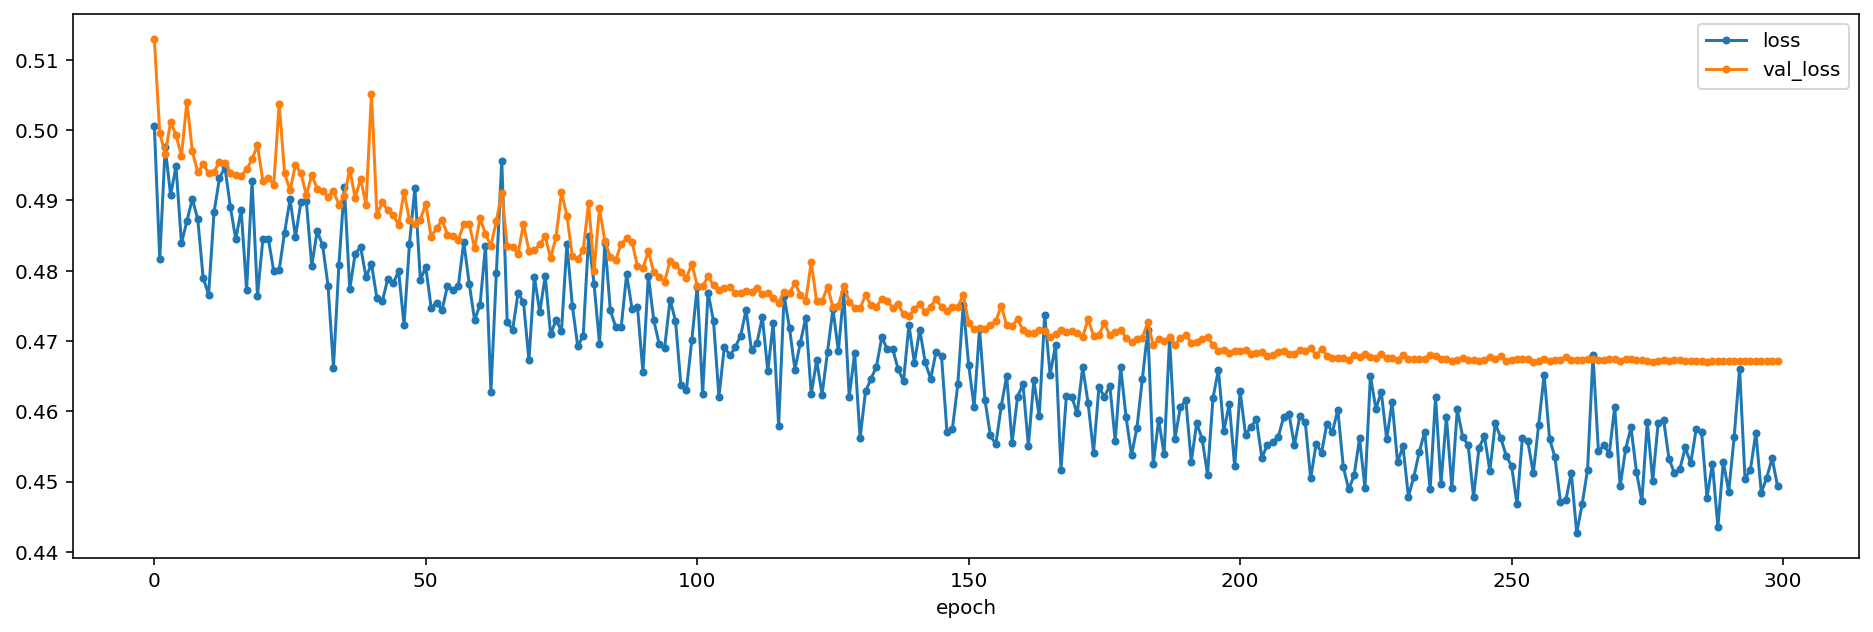

In [25]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);